In [1]:
import copy
import csv
import os
import re
import warnings
import random as python_random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


2025-07-04 14:10:41.227303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751631041.290103   74598 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751631041.308492   74598 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-04 14:10:41.374735: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
admissions = pd.read_csv("hosp/admissions.csv")
patients = pd.read_csv("hosp/patients.csv")
diagnoses = pd.read_csv("hosp/diagnoses_icd.csv")
icustays = pd.read_csv("icu/icustays.csv")
#chartevents = pd.read_csv("icu/chartevents.csv", chunksize=250000)  # Adjusted chunk size
labevents = pd.read_csv("hosp/labevents.csv")
discharge = pd.read_csv("discharge.csv")


In [3]:
#discharge = pd.read_csv("discharge.csv")
LVEF = discharge[discharge['text'].str.contains(r'LVEF')]

In [4]:
#LVEF_per = LVEF_new['text'].str.findall(r'LVEF.+?(?=%)')
#print(LVEF_per)
#LVEF_per = LVEF_new.loc[LVEF_new['text'].str.contains(r'LVEF.+?%', na=False)]
#print(LVEF_per)
LVEF_per = LVEF.copy()
LVEF_per['text'] = LVEF_per['text'].str.extract(r'(LVEF.+?%)')
print(LVEF_per)


               note_id  subject_id   hadm_id note_type  note_seq  \
9       10000764-DS-11    10000764  27897940        DS        11   
10      10000826-DS-17    10000826  20032235        DS        17   
18      10000980-DS-20    10000980  29654838        DS        20   
19      10000980-DS-21    10000980  26913865        DS        21   
24      10000980-DS-26    10000980  20897796        DS        26   
...                ...         ...       ...       ...       ...   
331782  19999784-DS-22    19999784  29889147        DS        22   
331783  19999784-DS-23    19999784  29956342        DS        23   
331784  19999784-DS-24    19999784  24755486        DS        24   
331790  19999840-DS-20    19999840  26071774        DS        20   
331792   19999987-DS-2    19999987  23865745        DS         2   

                  charttime            storetime         text  
9       2132-10-19 00:00:00  2132-10-19 18:50:00          NaN  
10      2146-12-12 00:00:00  2146-12-12 18:22:00    LVE

In [5]:
LVEF_gt = LVEF_per.copy()
LVEF_gt['text'] = LVEF_gt['text'].str.extract(r'(>.*[0-9]*)')
LVEF_gt = LVEF_gt.dropna(subset=['text'])
#print(LVEF_gt)
#print(LVEF_gt['text'].unique())
LVEF_gt['text'] = LVEF_gt['text'].str.extract(r'([0-9]+)')
#print(LVEF_gt['text'].unique())
gt_values = LVEF_gt.text.value_counts()
print(gt_values)

text
55    20087
60      404
75      225
65      210
70      130
50       68
40       10
45        5
47        2
43        1
20        1
64        1
30        1
32        1
80        1
71        1
25        1
58        1
Name: count, dtype: int64


In [6]:
LVEF_lt = LVEF_per.copy()
LVEF_lt['text'] = LVEF_lt['text'].str.extract(r'(<[<]*[ ]*[0-9]*)')
LVEF_lt = LVEF_lt.dropna(subset=['text'])
#print(LVEF_lt)
print(LVEF_lt['text'].unique())
LVEF_lt['text'] = LVEF_lt['text'].str.extract(r'([0-9]+)')
print(LVEF_lt['text'].unique())
lt_values = LVEF_lt.text.value_counts()
print(lt_values)

['<20' '< 20' '<40' '<35' '<30' '< 10' '<<20' '<' '< 30' '<10' '< 15'
 '<25' '< 40' '<15' '<<10' '< 25' '< 45']
['20' '40' '35' '30' '10' nan '15' '25' '45']
text
20    144
30     25
40     12
10      8
25      8
15      7
35      4
45      1
Name: count, dtype: int64


In [7]:
LVEF_et = LVEF_per.copy()
LVEF_et['text'] = LVEF_et['text'].str.extract(r'(=.*[0-9])')
LVEF_et = LVEF_et.dropna(subset=['text'])
#print(LVEF_et)
print(LVEF_et['text'].unique())
LVEF_et['text'] = LVEF_et['text'].str.extract(r'([0-9]+)')
print(LVEF_et['text'].unique())
et_values = LVEF_et.text.value_counts()
print(et_values)

['= ? 35-40' '= 25' '= 40-45' '= 64' '= 35-40' '= 65' '= 45-50' '= 59'
 '= 20' '= 68' '= 40' '= 35' '= 61' '= 79' '= 55' '= 60' '= 26' '= 15'
 '=45' '= 46' '= 40 - 45' '= 50-55' '= 72' '= 63' '= 41' '= 50' '= 21'
 '= 30' '= 45' '= 70' '=75' '= 13' '=25' '=64' '= 58' '= 36' '= 47' '= 53'
 '=40' '= 71' '= 52' '=55' '= 69' '= 57' '= 17' '= 56' '= 29' '=63' '=42'
 '= 62' '= 44' '= 55-60' '= 30 - 35' '=50' '= ? 40' '=59' '=55-60' '= 43'
 '=40-45' '= 27' '= 10 - 15' '= 67' '= <20' '= 20 - 25' '=70' '= 49'
 '= 33' '= 48' '=56' '= 15 - 20' '= 38' '=65' '=50-60' '= 45 - 50' '= 54'
 '=60' '= 60-65' '= 22' '= 25 - 30' '=30' '= 40-50' '= 37' '= 23'
 '= 15*-20' '= 42' '= >55' '= 24' '= 10' '=20' '= 66' '= 75' '= 34' '= 73'
 '= 3040' '= 14' '=58' '= 32' '=35' '= 19' '=30 to 40' '= ? 30' '= 74'
 '= 60-70' '= ?45-50' '= 77' '= ?40' '= 35- 40' '= 31' '= ?45' '= ~50'
 '= 35-45' '= < 10' '= 51' '= 50 - 55' '=45-50' '= 65-70' '=53' '= >60'
 '= 25 -30' '= 28' '= 45 to 50' '= 80' '= 78' '= 35 to 40' '= 39'


In [8]:
#print(gt_values, lt_values, et_values)
under_40 = sum([
    (LVEF_et['text'].astype(float) <= 40).sum(),
    (LVEF_gt['text'].astype(float) <= 40).sum(),
    (LVEF_lt['text'].astype(float) <= 40).sum()
])

between_40_50 = sum([
    ((LVEF_et['text'].astype(float) > 40) & (LVEF_et['text'].astype(float) <= 50)).sum(),
    ((LVEF_gt['text'].astype(float) > 40) & (LVEF_gt['text'].astype(float) <= 50)).sum(),
    ((LVEF_lt['text'].astype(float) > 40) & (LVEF_lt['text'].astype(float) <= 50)).sum()
])

over_50 = sum([
    (LVEF_et['text'].astype(float) > 50).sum(),
    (LVEF_gt['text'].astype(float) > 50).sum(),
    (LVEF_lt['text'].astype(float) > 50).sum()
])

print(f"Count under 40: {under_40}")
print(f"Count between 40 and 50: {between_40_50}")
print(f"Count over 50: {over_50}")

Count under 40: 4414
Count between 40 and 50: 2218
Count over 50: 24038


In [9]:
LVEF_all = pd.concat([pd.concat([LVEF_et, LVEF_gt], ignore_index=True),LVEF_lt], ignore_index=True)
print(LVEF_all)
LVEF_over_50 = LVEF_all[LVEF_all['text'].astype(float) >= 50]
print(LVEF_over_50)

              note_id  subject_id   hadm_id note_type  note_seq  \
0      10002495-DS-13    10002495  24982426        DS        13   
1      10004235-DS-21    10004235  24181354        DS        21   
2      10004401-DS-27    10004401  29988601        DS        27   
3      10004720-DS-11    10004720  22081550        DS        11   
4      10005817-DS-11    10005817  20626031        DS        11   
...               ...         ...       ...       ...       ...   
30683   19810932-DS-3    19810932  29764035        DS         3   
30684  19818243-DS-19    19818243  25296595        DS        19   
30685   19968075-DS-2    19968075  28592225        DS         2   
30686  19993336-DS-11    19993336  24615303        DS        11   
30687  19993336-DS-12    19993336  23077223        DS        12   

                 charttime            storetime text  
0      2141-05-29 00:00:00  2141-05-30 02:29:00   35  
1      2196-03-04 00:00:00  2196-03-06 10:57:00   25  
2      2144-02-06 00:00:00  21

In [10]:
LVEF_over_50 = LVEF_over_50.drop(['note_type', 'note_seq'], axis=1)
print(LVEF_over_50)

              note_id  subject_id   hadm_id            charttime  \
3      10004720-DS-11    10004720  22081550  2186-11-17 00:00:00   
5      10005817-DS-12    10005817  28661809  2135-01-19 00:00:00   
8      10011189-DS-13    10011189  23456305  2188-03-25 00:00:00   
10     10013643-DS-22    10013643  20023045  2200-10-28 00:00:00   
14     10018328-DS-15    10018328  23786647  2154-05-03 00:00:00   
...               ...         ...       ...                  ...   
30456  19999784-DS-21    19999784  23406899  2120-07-31 00:00:00   
30457  19999784-DS-22    19999784  29889147  2120-10-31 00:00:00   
30458  19999784-DS-23    19999784  29956342  2121-02-05 00:00:00   
30459  19999784-DS-24    19999784  24755486  2121-06-05 00:00:00   
30460  19999840-DS-20    19999840  26071774  2164-07-28 00:00:00   

                 storetime text  
3      2186-11-18 20:37:00   64  
5      2135-01-20 07:43:00   65  
8      2188-03-25 17:56:00   59  
10     2200-10-29 14:32:00   68  
14     2154-0

In [11]:
LVEF_over_50 = LVEF_over_50.rename(columns={"text": "LVEF"})
print(LVEF_over_50)


              note_id  subject_id   hadm_id            charttime  \
3      10004720-DS-11    10004720  22081550  2186-11-17 00:00:00   
5      10005817-DS-12    10005817  28661809  2135-01-19 00:00:00   
8      10011189-DS-13    10011189  23456305  2188-03-25 00:00:00   
10     10013643-DS-22    10013643  20023045  2200-10-28 00:00:00   
14     10018328-DS-15    10018328  23786647  2154-05-03 00:00:00   
...               ...         ...       ...                  ...   
30456  19999784-DS-21    19999784  23406899  2120-07-31 00:00:00   
30457  19999784-DS-22    19999784  29889147  2120-10-31 00:00:00   
30458  19999784-DS-23    19999784  29956342  2121-02-05 00:00:00   
30459  19999784-DS-24    19999784  24755486  2121-06-05 00:00:00   
30460  19999840-DS-20    19999840  26071774  2164-07-28 00:00:00   

                 storetime LVEF  
3      2186-11-18 20:37:00   64  
5      2135-01-20 07:43:00   65  
8      2188-03-25 17:56:00   59  
10     2200-10-29 14:32:00   68  
14     2154-0

In [12]:
# Filter diagnoses for relevant ICD codes
heart_failure_patients = diagnoses[diagnoses["icd_code"].isin(['I5030', '42830', 'I5031', '42831', 'I5032', '42832', 'I5033', '42833'])]

# Merge with LVEF
LVEF_patients = heart_failure_patients.merge(LVEF_over_50, on=["subject_id", "hadm_id"], how="inner")
# Merge with ICU stays
hf_icu = LVEF_patients.merge(icustays, on=["subject_id", "hadm_id"], how="inner")

# Extract unique ICU stay IDs
icu_ids = hf_icu["stay_id"].unique()
print(hf_icu, len(icu_ids))

      subject_id   hadm_id  seq_num icd_code  icd_version         note_id  \
0       10002013  23581541        2    42832            9   10002013-DS-7   
1       10011938  29339128        3    42831            9  10011938-DS-16   
2       10013643  22009484        2    42833            9  10013643-DS-21   
3       10014354  27487226        4    I5033           10  10014354-DS-18   
4       10014354  27487226        4    I5033           10  10014354-DS-18   
...          ...       ...      ...      ...          ...             ...   
2374    19997367  21508795       16    42832            9  19997367-DS-20   
2375    19997448  23560173        3    I5030           10  19997448-DS-13   
2376    19997448  23560173        3    I5030           10  19997448-DS-13   
2377    19998591  24349193        5    42832            9   19998591-DS-8   
2378    19998591  24349193        5    42832            9   19998591-DS-8   

                charttime            storetime LVEF   stay_id  \
0     2160

In [13]:
# Define ITEMIDs for relevant vitals (e.g., Heart Rate, BP, SpO2)
# Define ITEMIDs for vitals and labs
itemid_map = {
    "Heart Rate": 220045,
    "Systolic BP": 220179,
    "Diastolic BP": 220180,
    "SpO2": 220277,
    "Temperature": 223761,
    "BMI": 226512,
    "Bicarbonate": 227443,
    "Creatinine": 220615,
    "Hemoglobin": 220228,
    "INR(PT)": 220562,
    "Platelet Count": 227457,
    "Potassium": 220640,
    "WBC Count": 220546,
    "Sodium": 220645,
    "NT-proBNP": 227444,
    "Troponin T": 227429
}

# Check unique values for 'stay_id' and 'itemid' in a sample chunk
vitals_list = []
print("Unique ICU IDs:", icu_ids)
print(f"Number of unique ICU IDs: {len(icu_ids)}")

# Define chunk size
usecols = ["stay_id", "subject_id", "hadm_id", "charttime", "itemid", "valuenum"]
chunk_size = 5000  # Reduce if memory issues persist
filtered_rows = []

# Process the file in smaller chunks
with pd.read_csv("icu/chartevents.csv", usecols=usecols, chunksize=chunk_size) as reader:
    for chunk in reader:
        chunk["charttime"] = pd.to_datetime(chunk["charttime"])  # Convert datetime in chunks
        chunk_filtered = chunk[
            chunk["stay_id"].isin(icu_ids) & chunk["itemid"].isin(itemid_map.values())
        ]
        if not chunk_filtered.empty:
            filtered_rows.append(chunk_filtered)

# Concatenate filtered chunks if any data exists
if filtered_rows:
    vitals = pd.concat(filtered_rows, ignore_index=True)
    vitals.to_csv("filtered_vitals.csv", index=False)
    print(f"Filtered data saved with {len(vitals)} rows.")
else:
    print("No matching data found.")

'''
# Load relevant data
chunk_size = 1000  # Adjust the chunk size based on your available memory
vitals_list = []
for chunk in pd.read_csv("icu/chartevents.csv", chunksize=chunk_size):
    #chunk_filtered = chunk[(chunk["stay_id"].isin(icu_ids)) & (chunk["itemid"].isin(itemid_map.values()))]
    #vitals_list.append(chunk_filtered)
    #print(vitals_list)
    print(chunk)

# Concatenate all filtered chunks
vitals = pd.concat(vitals_list, ignore_index=True)
print(vitals)  # Check if the vitals dataframe is populated
'''

Unique ICU IDs: [39060235 31532954 33072499 ... 38134381 31144045 36794489]
Number of unique ICU IDs: 2341


/tmp/ipykernel_74598/74789829.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk["charttime"] = pd.to_datetime(chunk["charttime"])  # Convert datetime in chunks
/tmp/ipykernel_74598/74789829.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk["charttime"] = pd.to_datetime(chunk["charttime"])  # Convert datetime in chunks
/tmp/ipykernel_74598/74789829.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk["charttime"] = pd.to_datetime(chunk["charttime"])  # Convert datetime in chunks
/tmp/ipykernel_74598/74789829.py:35: UserWarning: Could not infer format,

Filtered data saved with 963208 rows.


'\n# Load relevant data\nchunk_size = 1000  # Adjust the chunk size based on your available memory\nvitals_list = []\nfor chunk in pd.read_csv("icu/chartevents.csv", chunksize=chunk_size):\n    #chunk_filtered = chunk[(chunk["stay_id"].isin(icu_ids)) & (chunk["itemid"].isin(itemid_map.values()))]\n    #vitals_list.append(chunk_filtered)\n    #print(vitals_list)\n    print(chunk)\n\n# Concatenate all filtered chunks\nvitals = pd.concat(vitals_list, ignore_index=True)\nprint(vitals)  # Check if the vitals dataframe is populated\n'

In [14]:
print(vitals)
print(patients.columns)
# Reverse map itemid to readable feature name
itemid_reverse_map = {v: k for k, v in itemid_map.items()}
vitals['feature'] = vitals['itemid'].map(itemid_reverse_map)

patient_counts = vitals.groupby('feature')['subject_id'].nunique().sort_values(ascending=False)
print(patient_counts)


        subject_id   hadm_id   stay_id           charttime  itemid  valuenum
0         10002013  23581541  39060235 2160-05-18 20:00:00  220045     103.0
1         10002013  23581541  39060235 2160-05-18 20:00:00  220277      97.0
2         10002013  23581541  39060235 2160-05-18 21:00:00  220045     105.0
3         10002013  23581541  39060235 2160-05-18 21:00:00  220277      98.0
4         10002013  23581541  39060235 2160-05-18 22:00:00  220045     101.0
...            ...       ...       ...                 ...     ...       ...
963203    19998591  24349193  36794489 2185-07-12 02:06:00  220546      12.1
963204    19998591  24349193  36794489 2185-07-12 02:06:00  227457     186.0
963205    19998591  24349193  36794489 2185-07-12 02:06:00  220615       0.7
963206    19998591  24349193  36794489 2185-07-12 02:06:00  220645     141.0
963207    19998591  24349193  36794489 2185-07-12 02:06:00  227443      27.0

[963208 rows x 6 columns]
Index(['subject_id', 'gender', 'anchor_age', 'anc

In [15]:
# Add death labels
admissions["admittime"] = pd.to_datetime(admissions["admittime"])
admissions["dischtime"] = pd.to_datetime(admissions["dischtime"])
admissions["deathtime"] = pd.to_datetime(admissions["deathtime"])

# Calculate death flags
admissions["death_within_30_days"] = (
    (admissions["deathtime"] - admissions["admittime"]).dt.days <= 30
) & admissions["deathtime"].notnull()

admissions["death_within_1_year"] = (
    (admissions["deathtime"] - admissions["admittime"]).dt.days <= 365
) & admissions["deathtime"].notnull()

admissions["death_within_2_years"] = (
    (admissions["deathtime"] - admissions["admittime"]).dt.days <= 730
) & admissions["deathtime"].notnull()

# Calculate age
patients["anchor_year"] = pd.to_numeric(patients["anchor_year"], errors="coerce")
patients["anchor_age"] = pd.to_numeric(patients["anchor_age"], errors="coerce")
patients["age_admission"] = patients["anchor_age"]  # or join using admittime year if needed

# Merge patient demographics with ICU data
demo = admissions.merge(patients[["subject_id", "gender", "anchor_age"]], on="subject_id", how="left")
demo = demo[["subject_id", "hadm_id", "death_within_30_days", "death_within_1_year", "death_within_2_years", "anchor_age", "gender", "admittime"]]
print(demo.head())

   subject_id   hadm_id  death_within_30_days  death_within_1_year  \
0    10000032  22595853                 False                False   
1    10000032  22841357                 False                False   
2    10000032  25742920                 False                False   
3    10000032  29079034                 False                False   
4    10000068  25022803                 False                False   

   death_within_2_years  anchor_age gender           admittime  
0                 False          52      F 2180-05-06 22:23:00  
1                 False          52      F 2180-06-26 18:27:00  
2                 False          52      F 2180-08-05 23:44:00  
3                 False          52      F 2180-07-23 12:35:00  
4                 False          19      F 2160-03-03 23:16:00  


In [16]:
# Map itemids to feature names
itemid_reverse_map = {v: k for k, v in itemid_map.items()}
vitals["label"] = vitals["itemid"].map(itemid_reverse_map)

# Sort and pivot
vitals.sort_values(by=["stay_id", "charttime"], inplace=True)
vitals_pivoted = vitals.pivot_table(
    index=["stay_id", "charttime"],
    columns="label",
    values="valuenum"
).reset_index()


In [17]:
# Resample at hourly intervals per ICU stay
vitals_pivoted['charttime'] = pd.to_datetime(vitals_pivoted['charttime'])
vitals_hourly = (
    vitals_pivoted
    .groupby("stay_id", group_keys=False)
    .apply(lambda x: x.set_index("charttime").resample("1H").mean().ffill(limit=6))
    .reset_index()
)



In [18]:
# Merge LVEF + ICU + demo
full = hf_icu.merge(demo, on=["subject_id", "hadm_id"], how="left")
full = full.merge(LVEF_over_50[["subject_id", "hadm_id", "LVEF"]], on=["subject_id", "hadm_id"], how="left")

# Merge with time-series vitals
full = vitals_hourly.merge(full, on="stay_id", how="inner")
full['gender'] = full['gender'].map({'M': 1, 'F': 0})

In [19]:
comorbidity_icd_map = {
    "AMI": {
        9: ["410"], 
        10: ["I21", "I22"]
    },
    "PVD": {
        9: ["440", "441", "443", "447", "557", "V43"],
        10: ["I70", "I71", "I73", "I77", "I79", "Z95"]
    },
    "CEVD": {
        9: ["430", "431", "432", "433", "434", "435", "436", "437", "438"],
        10: ["I60", "I61", "I62", "I63", "I64", "I65", "I66", "I67", "I68", "I69"]
    },
    "Dementia": {
        9: ["290"],
        10: ["F01", "F02", "F03"]
    },
    "COPD": {
        9: ["490", "491", "492", "493", "494", "495", "496"],
        10: ["J40", "J41", "J42", "J43", "J44"]
    },
    "Rheumatoid Disease": {
        9: ["714"],
        10: ["M05", "M06"]
    },
    "PUD": {
        9: ["531", "532", "533", "534"],
        10: ["K25", "K26", "K27", "K28"]
    },
    "Mild LD": {
        9: ["571.2", "571.4", "571.5", "571.6"],
        10: ["K70.0", "K73", "K74"]
    },
    "Moderate/Severe LD": {
        9: ["572.2", "572.3", "572.4", "572.8"],
        10: ["K72", "K76.6", "I85", "I86.4"]
    },
    "Diabetes": {
        9: ["250"],
        10: ["E10", "E11"]
    },
    "Diabetes + Complications": {
        9: ["250.4", "250.5", "250.6", "250.7"],
        10: ["E10.2", "E11.2", "E10.3", "E11.3", "E10.4", "E11.4"]
    },
    "HP/PAPL": {
        9: ["342", "344.1"],
        10: ["G81", "G82"]
    },
    "RD": {
        9: ["585"],
        10: ["N18"]
    },
    "Cancer": {
        9: [str(i) for i in range(140, 173)] + [str(i) for i in range(174, 195)],
        10: ["C00", "C01", "C02", "C15", "C16", "C50", "C60", "C70", "C75"]
    },
    "Metastatic Cancer": {
        9: ["196", "197", "198", "199"],
        10: ["C77", "C78", "C79", "C80"]
    },
    "Hypertension": {
        9: ["401"],
        10: ["I10"]
    },
    "Coronary Artery Disease": {
        9: ["414"],
        10: ["I25"]
    },
    "Pulmonary Hypertension": {
        9: ["416.0", "416.8"],
        10: ["I27"]
    },
    "Atrial Fibrillation": {
        9: ["427.31"],
        10: ["I48"]
    }
}


In [20]:
def create_mimic_comorbidity_flags(diagnoses_df, comorbidity_icd_map):
    diagnoses_df = diagnoses_df.copy()
    diagnoses_df["icd_code_str"] = diagnoses_df["icd_code"].astype(str)

    # Strip decimal points for ICD-9 compatibility
    diagnoses_df["icd_code_str"] = diagnoses_df["icd_code_str"].str.replace(r"\.", "", regex=True)

    # Initialize comorbidity matrix
    comorb_flags = diagnoses_df[["subject_id", "hadm_id"]].drop_duplicates().copy()
    
    for comorb, version_map in comorbidity_icd_map.items():
        matched = pd.Series(False, index=diagnoses_df.index)
        for icd_version, patterns in version_map.items():
            mask = diagnoses_df["icd_version"] == icd_version
            codes = diagnoses_df.loc[mask, "icd_code_str"]
            pattern = "|".join([f"^{code}" for code in patterns])
            matched |= codes.str.contains(pattern, regex=True, na=False)
        diagnoses_df[comorb] = matched

    # Reduce to patient-level indicators
    comorb_columns = list(comorbidity_icd_map.keys())
    return diagnoses_df.groupby(["subject_id", "hadm_id"])[comorb_columns].max().reset_index()


In [21]:
comorbidity_df = create_mimic_comorbidity_flags(diagnoses, comorbidity_icd_map)
full = full.merge(comorbidity_df, on=["subject_id", "hadm_id"], how="left")

# Fill NA with 0s
comorb_cols = list(comorbidity_icd_map.keys())
full[comorb_cols] = full[comorb_cols].fillna(0).astype(int)


In [22]:
full.drop(columns=["LVEF_x", "charttime_y"], inplace=True)
full.rename(columns={"LVEF_y": "LVEF", "charttime_x": "charttime"}, inplace=True)

In [23]:
# Select relevant columns

print("Columns in final_dataset:")
print(full.columns.tolist())
pd.options.display.max_columns = None
print(full.tail())

features = [
    "Heart Rate", "Systolic BP", "SpO2", "Temperature", "BMI",
    "Bicarbonate", "Creatinine", "Hemoglobin", "Platelet Count",
    "WBC Count", "Sodium", "NT-proBNP", "Troponin T"
]

scaler = MinMaxScaler()
full[features] = scaler.fit_transform(full[features])
# Drop duplicates based on hadm_id and icd_code
unique_icd = full[['subject_id','hadm_id', 'icd_code']].drop_duplicates()

# Count how many times each icd_code appears across unique admissions
counts = unique_icd['icd_code'].value_counts()
print(counts)



Columns in final_dataset:
['charttime', 'stay_id', 'BMI', 'Bicarbonate', 'Creatinine', 'Diastolic BP', 'Heart Rate', 'Hemoglobin', 'NT-proBNP', 'Platelet Count', 'Sodium', 'SpO2', 'Systolic BP', 'Temperature', 'Troponin T', 'WBC Count', 'subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version', 'note_id', 'storetime', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los', 'death_within_30_days', 'death_within_1_year', 'death_within_2_years', 'anchor_age', 'gender', 'admittime', 'LVEF', 'AMI', 'PVD', 'CEVD', 'Dementia', 'COPD', 'Rheumatoid Disease', 'PUD', 'Mild LD', 'Moderate/Severe LD', 'Diabetes', 'Diabetes + Complications', 'HP/PAPL', 'RD', 'Cancer', 'Metastatic Cancer', 'Hypertension', 'Coronary Artery Disease', 'Pulmonary Hypertension', 'Atrial Fibrillation']
                 charttime     stay_id  BMI  Bicarbonate  Creatinine  \
234808 2112-12-13 15:00:00  39990748.0  NaN          NaN         NaN   
234809 2112-12-13 16:00:00  39990748.0  NaN          NaN         NaN 

In [24]:
full.to_csv("final_heart_failure_timeseries.csv", index=False)


In [25]:
window_size = 24  # hours
segments = []

for stay_id, group in full.groupby("stay_id"):
    if len(group) >= window_size:
        segment = group.iloc[:window_size]
        segments.append(segment)

# This produces a list of time-series windows


In [26]:
X = []
y_30d = []
y_1y = []
y_2y = []
comorbidity_columns = list(comorbidity_icd_map.keys())
for stay_id, group in full.groupby("stay_id"):
    if len(group) >= window_size:
        segment = group.iloc[:window_size]
        
        # Repeat gender_numeric over time dimension
        gender_array = np.repeat(segment['gender'].iloc[0], window_size).reshape(-1, 1)
        
        # Select features and comorbidities
        time_series_features = segment[features + comorbidity_columns].values
        
        # Concatenate gender column (static) to each time step
        combined_features = np.hstack([time_series_features, gender_array])
        
        X.append(combined_features)
        y_30d.append(segment["death_within_30_days"].iloc[0])
        y_1y.append(segment["death_within_1_year"].iloc[0])
        y_2y.append(segment["death_within_2_years"].iloc[0])



In [27]:
X = np.array(X)
y_30d = np.array(y_30d)
y_1y = np.array(y_1y)
y_2y = np.array(y_2y)
print(X,y_30d,y_1y,y_2y)


[[[7.83333333e-02 1.09663334e-04 1.98408598e-02 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [7.61111111e-02 1.15644970e-04 1.99441976e-02 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [6.33333333e-02 1.03681697e-04 2.00475354e-02 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  ...
  [7.00000000e-02 1.06672515e-04 2.00475354e-02 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [6.88888889e-02 1.13651091e-04 2.00475354e-02 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [7.77777778e-02 1.11657212e-04 1.98408598e-02 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]]

 [[           nan            nan            nan ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [           nan            nan            nan ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [           nan            nan            nan ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  ...
  [1.00000000e-01            nan 1.96341841e-02 ... 0.00000000e+00
   0.00000

In [28]:
#comorbidities cohort

Total number of male patients: 732
Total number of female patients: 1034


/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Comorbidity prevalence per cluster:
              AMI       PVD      CEVD  Dementia      COPD  Rheumatoid Disease  \
cluster                                                                         
0        0.093702  0.273425  0.125960  0.030722  0.376344            0.033794   
1        0.075515  0.141876  0.098398  0.041190  0.386728            0.036613   
2        0.113523  0.133556  0.108514  0.036728  0.307179            0.023372   
3        0.218289  0.849558  0.138643  0.053097  0.401180            0.008850   

              PUD   Mild LD  Moderate/Severe LD  Diabetes  \
cluster                                                     
0        0.023041  0.009217            0.001536  0.376344   
1        0.009153  0.027460            0.034325  0.302059   
2        0.028381  0.018364            0.016694  0.569282   
3        0.026549  0.050147            0.014749  0.560472   

         Diabetes + Complications   HP/PAPL        RD    Cancer  \
cluster                                    

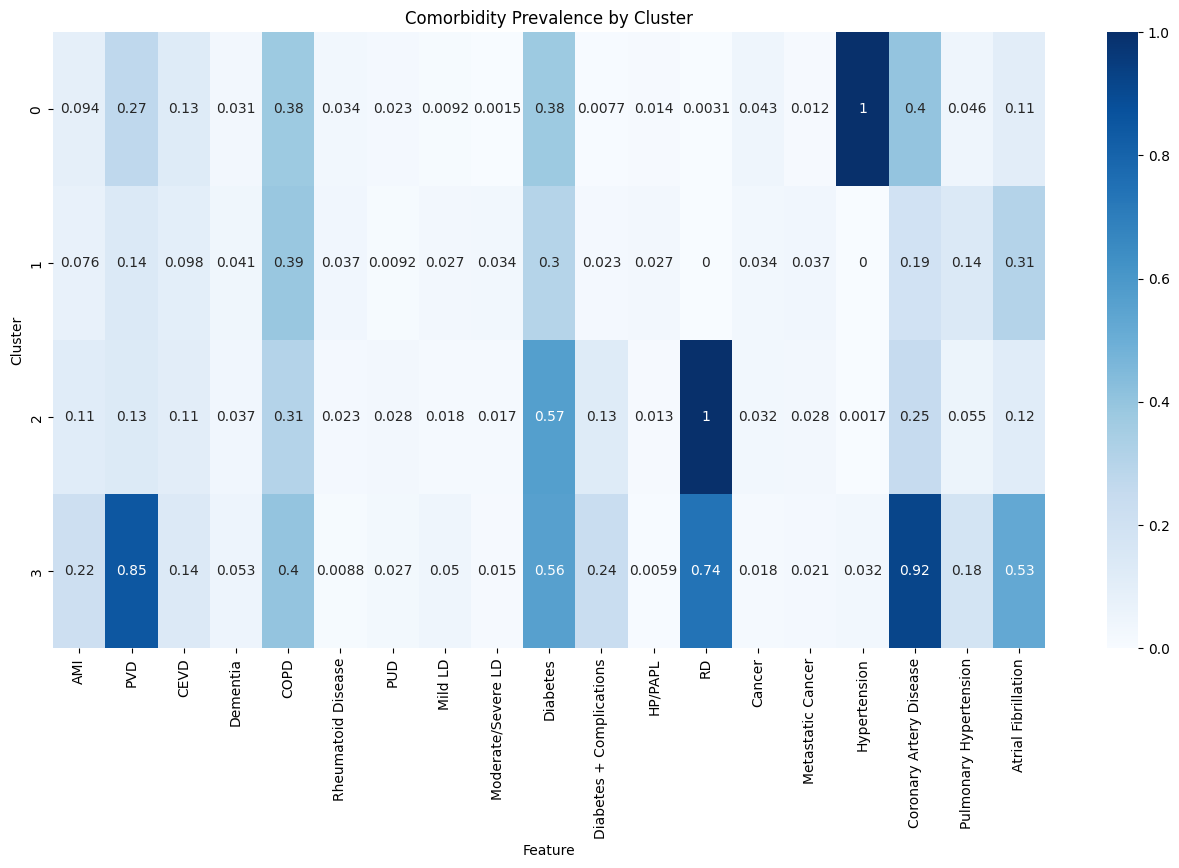

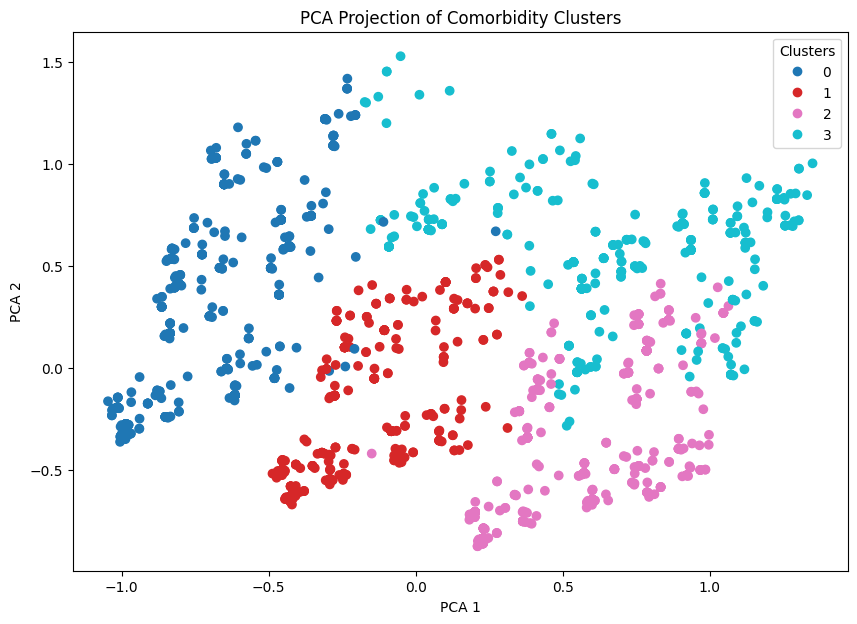


Most prevalent comorbidities per cluster:

Cluster 0 (651 patients):
  - Hypertension: 100.0%
  - Coronary Artery Disease: 40.1%
  - COPD: 37.6%
  - Diabetes: 37.6%

Cluster 1 (437 patients):
  - COPD: 38.7%
  - Atrial Fibrillation: 30.7%
  - Diabetes: 30.2%

Cluster 2 (599 patients):
  - RD: 100.0%
  - Diabetes: 56.9%
  - COPD: 30.7%

Cluster 3 (339 patients):
  - Coronary Artery Disease: 92.0%
  - PVD: 85.0%
  - RD: 74.0%
  - Diabetes: 56.0%
  - Atrial Fibrillation: 52.5%
  - COPD: 40.1%


In [29]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

num_males = full[full["gender"] == 1]["subject_id"].nunique()
num_females = full[full["gender"] == 0]["subject_id"].nunique()


print(f"Total number of male patients: {num_males}")
print(f"Total number of female patients: {num_females}")

# Assume `full` dataframe is loaded with comorbidity flags and other features as in your preprocessing

# 1. Extract comorbidity columns
comorbidity_columns = [
    "AMI", "PVD", "CEVD", "Dementia", "COPD", "Rheumatoid Disease", "PUD",
    "Mild LD", "Moderate/Severe LD", "Diabetes", "Diabetes + Complications",
    "HP/PAPL", "RD", "Cancer", "Metastatic Cancer", "Hypertension",
    "Coronary Artery Disease", "Pulmonary Hypertension", "Atrial Fibrillation"
]

# Get unique patient-hadm_id combinations to cluster on comorbidities at admission level
comorbidity_data = full[["subject_id", "hadm_id"] + comorbidity_columns].drop_duplicates(subset=["subject_id", "hadm_id"])

# 2. Clustering based on comorbidities
X_comorb = comorbidity_data[comorbidity_columns].values

# Choose number of clusters (e.g., 4), could be tuned with silhouette score or elbow method
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_comorb)

comorbidity_data['cluster'] = clusters
# Map (subject_id, hadm_id) → cluster
hadm_cluster_map = {
    (row.subject_id, row.hadm_id): row.cluster
    for row in comorbidity_data.itertuples(index=False)
}
# 3. Characterize clusters by comorbidity prevalence
cluster_summary = comorbidity_data.groupby('cluster')[comorbidity_columns].mean()

print("Comorbidity prevalence per cluster:")
print(cluster_summary)

# 4. Visualization: Heatmap of comorbidity prevalence per cluster
plt.figure(figsize=(16, 8))
sns.heatmap(cluster_summary, annot=True, cmap="Blues", cbar=True)
plt.title("Comorbidity Prevalence by Cluster")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.savefig(f"ComorbidityPrevalence_k={n_clusters}.png")
plt.show()

# 5. Optional: Use PCA to visualize patient distribution in 2D by clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_comorb)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("PCA Projection of Comorbidity Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.savefig(f"PCAClusters_k={n_clusters}.png")
plt.show()

# 6. Print comorbidities per cluster (based on prevalence)

# Define threshold for considering a comorbidity "common" in a cluster
threshold = 0.3

print("\nMost prevalent comorbidities per cluster:")
for cluster_id, row in cluster_summary.iterrows():
    prevalent = row[row >= threshold].sort_values(ascending=False)
    cluster_size = len(comorbidity_data[comorbidity_data['cluster'] == cluster_id])
    print(f"\nCluster {cluster_id} ({cluster_size} patients):")
    if prevalent.empty:
        print("  No comorbidities above threshold.")
    else:
        for comorb, value in prevalent.items():
            print(f"  - {comorb}: {value:.1%}")


In [30]:

from collections import defaultdict
# ========== Extract time series windows ==========
window_size = 24
segments = []

X = []
y_30d = []
y_1y = []
y_2y = []
subject_hadm_ids = []

for (subject_id, hadm_id), group in full.groupby(["subject_id", "hadm_id"]):
    if len(group) >= window_size:
        segment = group.iloc[:window_size]
        gender_array = np.repeat(segment["gender"].iloc[0], window_size).reshape(-1, 1)
        time_series_features = segment[features].values
        #combined_features = np.hstack([time_series_features, gender_array])
        
        X.append(time_series_features)
        y_30d.append(segment["death_within_30_days"].iloc[0])
        y_1y.append(segment["death_within_1_year"].iloc[0])
        y_2y.append(segment["death_within_2_years"].iloc[0])
        subject_hadm_ids.append((subject_id, hadm_id))

X = np.array(X)
y_30d = np.array(y_30d)
y_1y = np.array(y_1y)
y_2y = np.array(y_2y)

# ========== Split time series into clusters ==========
cluster_X = defaultdict(list)
cluster_y_30d = defaultdict(list)
cluster_y_1y = defaultdict(list)
cluster_y_2y = defaultdict(list)

for i, (sid, hid) in enumerate(subject_hadm_ids):
    cluster_id = hadm_cluster_map.get((sid, hid), None)
    if cluster_id is not None:
        cluster_X[cluster_id].append(X[i])
        cluster_y_30d[cluster_id].append(y_30d[i])
        cluster_y_1y[cluster_id].append(y_1y[i])
        cluster_y_2y[cluster_id].append(y_2y[i])

# Convert lists to arrays
for cid in range(n_clusters):
    cluster_X[cid] = np.array(cluster_X[cid])
    cluster_y_30d[cid] = np.array(cluster_y_30d[cid])
    cluster_y_1y[cid] = np.array(cluster_y_1y[cid])
    cluster_y_2y[cid] = np.array(cluster_y_2y[cid])
    print(f"Cluster {cid}: {cluster_X[cid].shape[0]} samples")


Cluster 0: 599 samples
Cluster 1: 399 samples
Cluster 2: 522 samples
Cluster 3: 303 samples


In [31]:
for cid in range(n_clusters):
    print(cluster_X[cid].shape)
    print(cluster_y_2y[cid].shape)

(599, 24, 13)
(599,)
(399, 24, 13)
(399,)
(522, 24, 13)
(522,)
(303, 24, 13)
(303,)


In [32]:
import os

save_dir = "cluster_csv"
os.makedirs(save_dir, exist_ok=True)

for cid in range(n_clusters):
    cluster_folder = os.path.join(save_dir, f"cluster_30d_{cid}")
    os.makedirs(cluster_folder, exist_ok=True)

    for i, x in enumerate(cluster_X[cid]):
        df = pd.DataFrame(x)
        df["label_30d"] = cluster_y_30d[cid][i]  # Append label to each row (repeated)
        df.to_csv(os.path.join(cluster_folder, f"sample_{i}.csv"), index=False)

    print(f"Saved {len(cluster_X[cid])} samples to {cluster_folder}")

for cid in range(n_clusters):
    cluster_folder = os.path.join(save_dir, f"cluster_1y_{cid}")
    os.makedirs(cluster_folder, exist_ok=True)

    for i, x in enumerate(cluster_X[cid]):
        df = pd.DataFrame(x)
        df["label_1y"] = cluster_y_1y[cid][i]  # Append label to each row (repeated)
        df.to_csv(os.path.join(cluster_folder, f"sample_{i}.csv"), index=False)

    print(f"Saved {len(cluster_X[cid])} samples to {cluster_folder}")

for cid in range(n_clusters):
    cluster_folder = os.path.join(save_dir, f"cluster_2y_{cid}")
    os.makedirs(cluster_folder, exist_ok=True)

    for i, x in enumerate(cluster_X[cid]):
        df = pd.DataFrame(x)
        df["label_2y"] = cluster_y_2y[cid][i]  # Append label to each row (repeated)
        df.to_csv(os.path.join(cluster_folder, f"sample_{i}.csv"), index=False)

    print(f"Saved {len(cluster_X[cid])} samples to {cluster_folder}")


Saved 599 samples to cluster_csv/cluster_30d_0
Saved 399 samples to cluster_csv/cluster_30d_1
Saved 522 samples to cluster_csv/cluster_30d_2
Saved 303 samples to cluster_csv/cluster_30d_3
Saved 599 samples to cluster_csv/cluster_1y_0
Saved 399 samples to cluster_csv/cluster_1y_1
Saved 522 samples to cluster_csv/cluster_1y_2
Saved 303 samples to cluster_csv/cluster_1y_3
Saved 599 samples to cluster_csv/cluster_2y_0
Saved 399 samples to cluster_csv/cluster_2y_1
Saved 522 samples to cluster_csv/cluster_2y_2
Saved 303 samples to cluster_csv/cluster_2y_3


In [33]:
import os
import pandas as pd

save_dir = "cluster_csv"
os.makedirs(save_dir, exist_ok=True)

for cid in range(n_clusters):
    cluster_folder = os.path.join(save_dir, f"cluster_{cid}")
    os.makedirs(cluster_folder, exist_ok=True)

    for i, x in enumerate(cluster_X[cid]):
        df = pd.DataFrame(x)
        df["label_30d"] = cluster_y_30d[cid][i]
        df["label_1y"] = cluster_y_1y[cid][i]
        df["label_2y"] = cluster_y_2y[cid][i]
        df.to_csv(os.path.join(cluster_folder, f"sample_{i}.csv"), index=False)

    print(f"Saved {len(cluster_X[cid])} samples to {cluster_folder}")

Saved 599 samples to cluster_csv/cluster_0
Saved 399 samples to cluster_csv/cluster_1
Saved 522 samples to cluster_csv/cluster_2
Saved 303 samples to cluster_csv/cluster_3



===== Gender: Male =====


/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Comorbidity prevalence per cluster:
              AMI       PVD      CEVD  Dementia      COPD  Rheumatoid Disease  \
cluster                                                                         
0        0.111607  0.116071  0.116071  0.044643  0.348214            0.004464   
1        0.115741  0.324074  0.097222  0.018519  0.379630            0.018519   
2        0.161943  0.259109  0.105263  0.048583  0.344130            0.032389   
3        0.189781  0.846715  0.116788  0.051095  0.357664            0.000000   

              PUD   Mild LD  Moderate/Severe LD  Diabetes  \
cluster                                                     
0        0.031250  0.022321            0.049107  0.000000   
1        0.027778  0.013889            0.004630  0.439815   
2        0.028340  0.024291            0.012146  1.000000   
3        0.021898  0.072993            0.036496  0.255474   

         Diabetes + Complications   HP/PAPL        RD    Cancer  \
cluster                                    

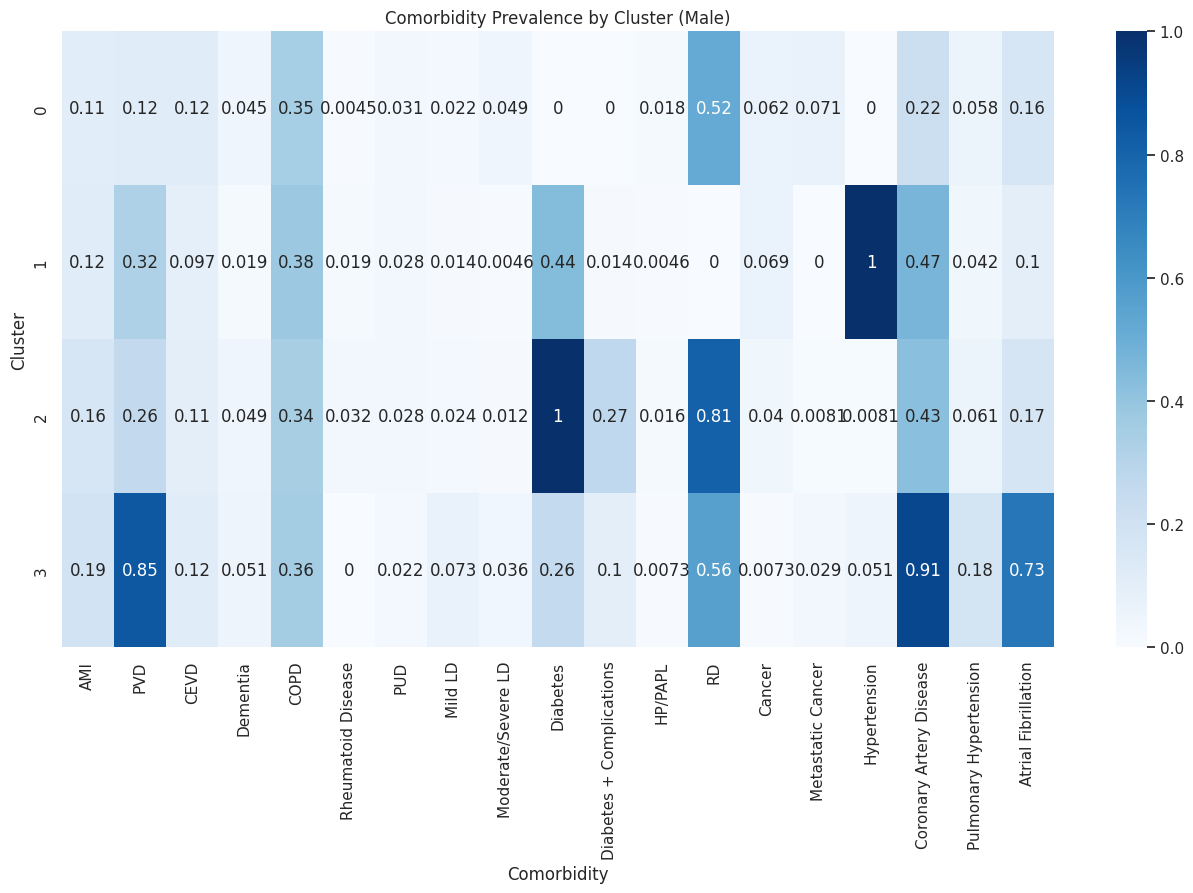

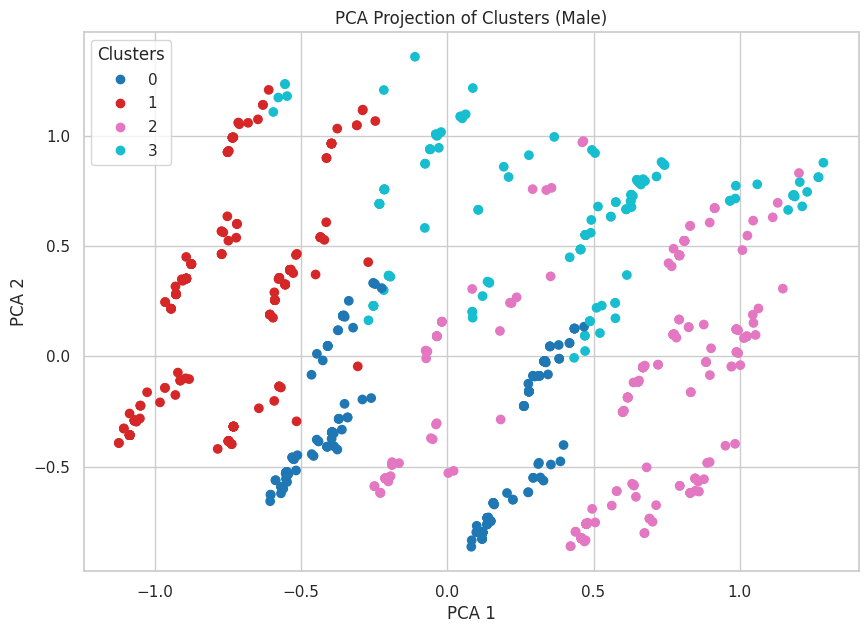


Most prevalent comorbidities per cluster:

Cluster 0 (224 patients):
  - RD: 51.8%
  - COPD: 34.8%

Cluster 1 (216 patients):
  - Hypertension: 100.0%
  - Coronary Artery Disease: 46.8%
  - Diabetes: 44.0%
  - COPD: 38.0%
  - PVD: 32.4%

Cluster 2 (247 patients):
  - Diabetes: 100.0%
  - RD: 81.0%
  - Coronary Artery Disease: 42.5%
  - COPD: 34.4%

Cluster 3 (137 patients):
  - Coronary Artery Disease: 91.2%
  - PVD: 84.7%
  - Atrial Fibrillation: 73.0%
  - RD: 56.2%
  - COPD: 35.8%

===== Gender: Female =====


/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Comorbidity prevalence per cluster:
              AMI       PVD      CEVD  Dementia      COPD  Rheumatoid Disease  \
cluster                                                                         
0        0.062284  0.231834  0.124567  0.038062  1.000000            0.048443   
1        0.138973  0.329305  0.138973  0.030211  0.299094            0.018127   
2        0.099359  0.278846  0.102564  0.048077  0.166667            0.028846   
3        0.092593  0.255556  0.125926  0.033333  0.000000            0.048148   

              PUD   Mild LD  Moderate/Severe LD  Diabetes  \
cluster                                                     
0        0.013841  0.013841            0.010381  0.408304   
1        0.018127  0.027190            0.015106  1.000000   
2        0.016026  0.022436            0.009615  0.000000   
3        0.025926  0.007407            0.000000  0.303704   

         Diabetes + Complications   HP/PAPL        RD    Cancer  \
cluster                                    

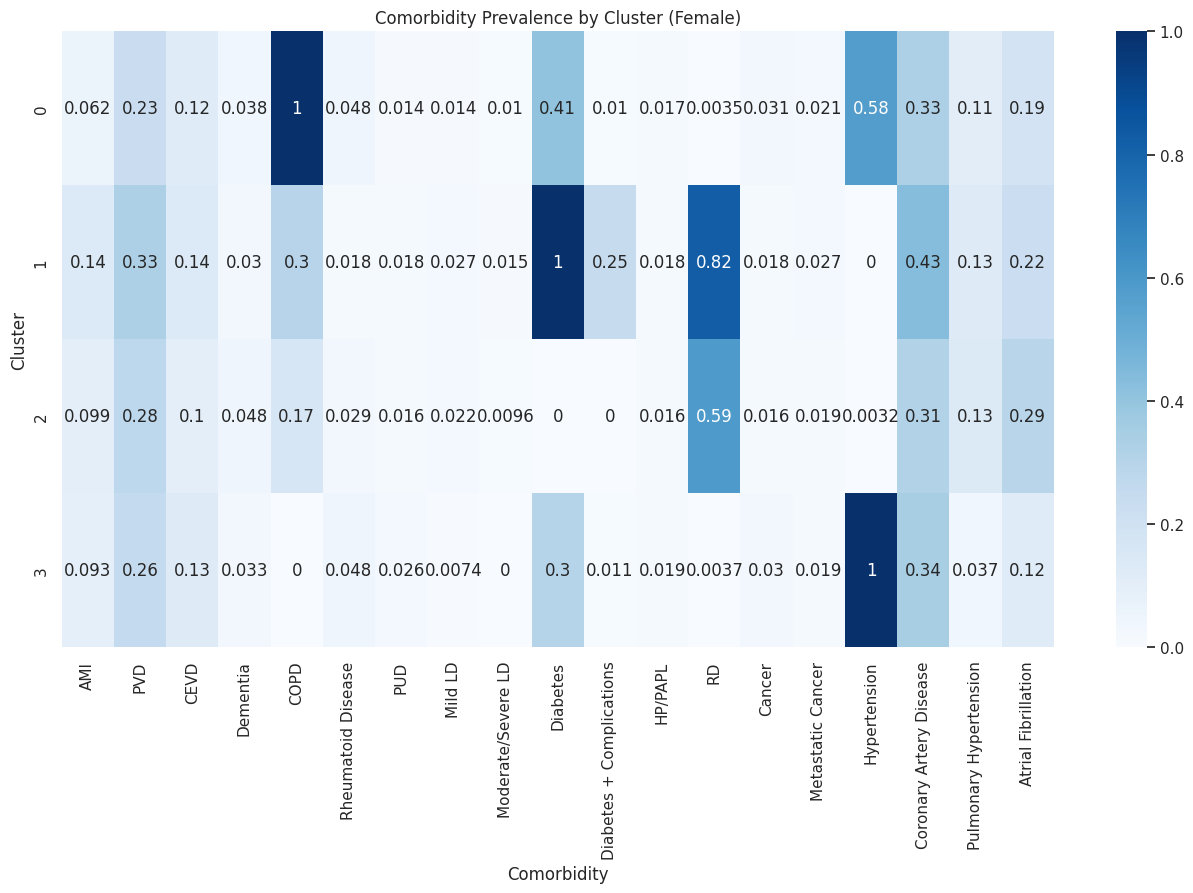

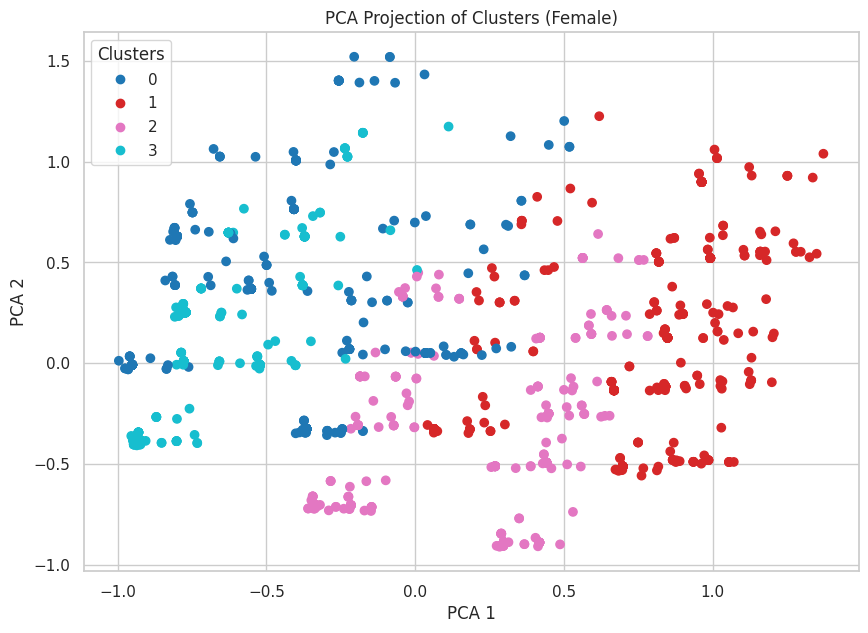


Most prevalent comorbidities per cluster:

Cluster 0 (289 patients):
  - COPD: 100.0%
  - Hypertension: 57.8%
  - Diabetes: 40.8%
  - Coronary Artery Disease: 32.9%

Cluster 1 (331 patients):
  - Diabetes: 100.0%
  - RD: 82.5%
  - Coronary Artery Disease: 43.2%
  - PVD: 32.9%

Cluster 2 (312 patients):
  - RD: 59.0%
  - Coronary Artery Disease: 31.4%

Cluster 3 (270 patients):
  - Hypertension: 100.0%
  - Coronary Artery Disease: 34.4%
  - Diabetes: 30.4%


In [34]:
# Set visual styles
sns.set(style="whitegrid")

# Assumed already loaded: `full` dataframe with comorbidities + gender
comorbidity_columns = [
    "AMI", "PVD", "CEVD", "Dementia", "COPD", "Rheumatoid Disease", "PUD",
    "Mild LD", "Moderate/Severe LD", "Diabetes", "Diabetes + Complications",
    "HP/PAPL", "RD", "Cancer", "Metastatic Cancer", "Hypertension",
    "Coronary Artery Disease", "Pulmonary Hypertension", "Atrial Fibrillation"
]

# Threshold for a comorbidity to be considered prevalent in a cluster
threshold = 0.3
n_clusters = 4

# Loop over genders
for gender in [1, 0]:
    gender_label = "Male" if gender == 1 else "Female"
    print(f"\n===== Gender: {gender_label} =====")

    # Filter gender-specific data
    gender_data = full[full["gender"] == gender]

    comorb_data = gender_data[["subject_id", "hadm_id"] + comorbidity_columns].drop_duplicates(subset=["subject_id", "hadm_id"])

    # Check for empty data
    if comorb_data.empty:
        print(f"Skipping {gender_label} cohort (no data available).")
        continue

    X_comorb = comorb_data[comorbidity_columns].values

    # Check if enough samples for clustering
    if len(X_comorb) < n_clusters:
        print(f"Skipping {gender_label} cohort (only {len(X_comorb)} samples, need at least {n_clusters}).")
        continue

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_comorb)
    comorb_data = comorb_data.copy()
    comorb_data['cluster'] = clusters

    # Summary table
    cluster_summary = comorb_data.groupby('cluster')[comorbidity_columns].mean()
    print("Comorbidity prevalence per cluster:")
    print(cluster_summary)

    # Heatmap
    plt.figure(figsize=(16, 8))
    sns.heatmap(cluster_summary, annot=True, cmap="Blues", cbar=True)
    plt.title(f"Comorbidity Prevalence by Cluster ({gender_label})")
    plt.ylabel("Cluster")
    plt.xlabel("Comorbidity")
    plt.savefig(f"ComorbidityPrevalence{gender_label}.png")
    plt.show()

    # PCA visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_comorb)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10')
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.title(f"PCA Projection of Clusters ({gender_label})")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.savefig(f"PCAClusters{gender_label}.png")
    plt.show()


    # Prevalent comorbidities per cluster
    print("\nMost prevalent comorbidities per cluster:")
    for cluster_id, row in cluster_summary.iterrows():
        prevalent = row[row >= threshold].sort_values(ascending=False)
        cluster_size = len(comorb_data[comorb_data['cluster'] == cluster_id])
        print(f"\nCluster {cluster_id} ({cluster_size} patients):")
        if prevalent.empty:
            print("  No comorbidities above threshold.")
        else:
            for comorb, value in prevalent.items():
                print(f"  - {comorb}: {value:.1%}")


In [35]:

num_males = full[full["gender"] == 1]["subject_id"].nunique()
num_females = full[full["gender"] == 0]["subject_id"].nunique()


print(f"Total number of male patients: {num_males}")
print(f"Total number of female patients: {num_females}")

Total number of male patients: 732
Total number of female patients: 1034


In [36]:
total_patients = full["subject_id"].nunique()
total_admissions = full[["subject_id", "hadm_id"]].drop_duplicates().shape[0]

print(f"Total unique patients: {total_patients}")
print(f"Total unique admissions (subject_id, hadm_id pairs): {total_admissions}")


Total unique patients: 1766
Total unique admissions (subject_id, hadm_id pairs): 2026


In [37]:
# Group by subject_id to get one row per patient
death_per_patient = full.groupby("subject_id")[[
    "death_within_30_days", "death_within_1_year", "death_within_2_years"
]].max()  # Or use `.any()` to convert to boolean

# Print unique patient-level label distribution
print("\nLabel distribution per unique patient (0 = alive, 1 = dead):")
print("death_within_30_days:\n", death_per_patient["death_within_30_days"].value_counts(dropna=False))
print("death_within_1_year:\n", death_per_patient["death_within_1_year"].value_counts(dropna=False))
print("death_within_2_years:\n", death_per_patient["death_within_2_years"].value_counts(dropna=False))



Label distribution per unique patient (0 = alive, 1 = dead):
death_within_30_days:
 death_within_30_days
False    1633
True      133
Name: count, dtype: int64
death_within_1_year:
 death_within_1_year
False    1620
True      146
Name: count, dtype: int64
death_within_2_years:
 death_within_2_years
False    1620
True      146
Name: count, dtype: int64


Total number of male patients: 732
Total number of female patients: 1034


/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Comorbidity prevalence + prior admission by cluster:
              AMI       PVD      CEVD  Dementia      COPD  Rheumatoid Disease  \
cluster                                                                         
0        0.069652  0.246269  0.111940  0.049751  0.375622            0.039801   
1        0.074550  0.239075  0.092545  0.048843  0.321337            0.023136   
2        0.102787  0.271777  0.125436  0.033101  0.378049            0.033101   
3        0.254364  0.488778  0.142145  0.037406  0.361596            0.007481   

              PUD   Mild LD  Moderate/Severe LD  Diabetes  \
cluster                                                     
0        0.009950  0.034826            0.034826  0.223881   
1        0.035990  0.023136            0.017995  0.524422   
2        0.019164  0.008711            0.001742  0.376307   
3        0.019950  0.037406            0.014963  0.643392   

         Diabetes + Complications   HP/PAPL        RD    Cancer  \
cluster                   

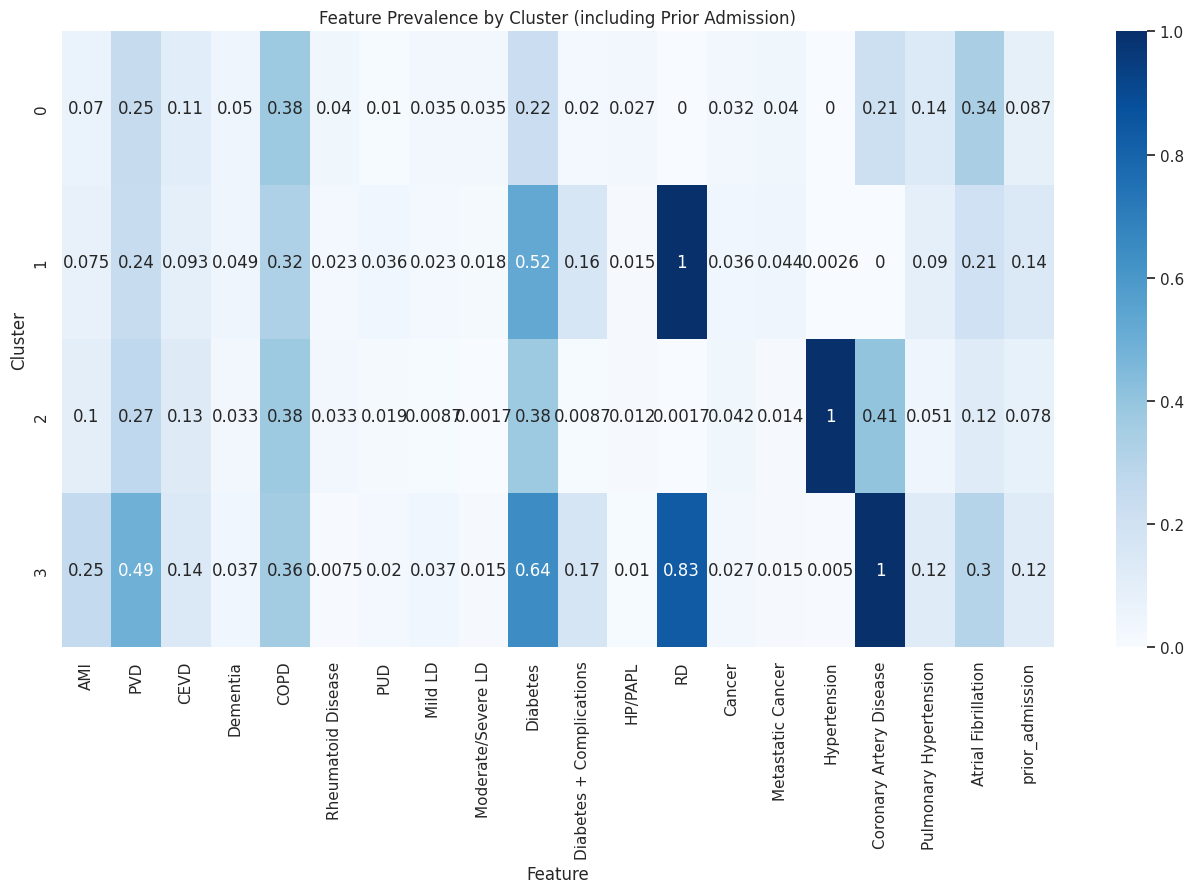

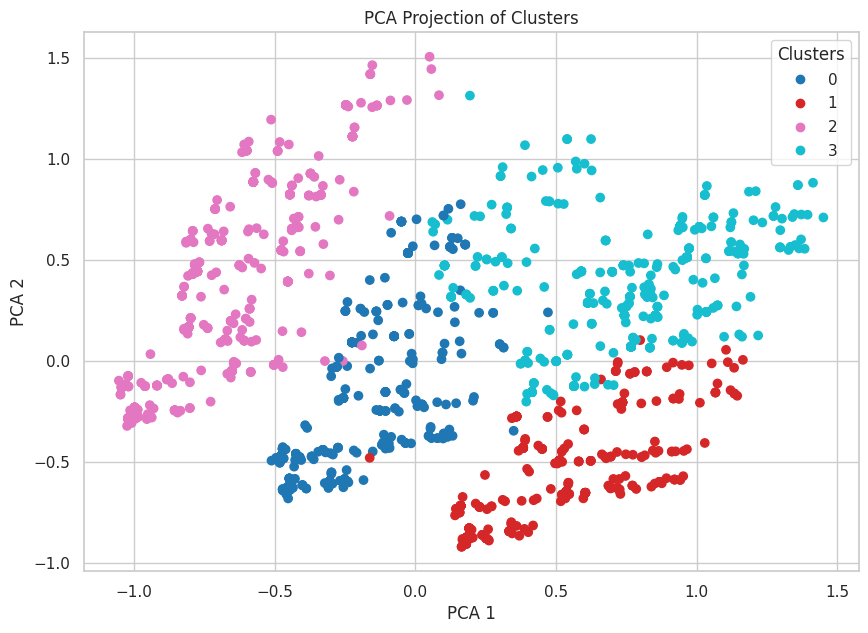


Most prevalent features per cluster (threshold >= 30%):

Cluster 0 (402 patients):
  - COPD: 37.6%
  - Atrial Fibrillation: 33.8%
  - PVD: 24.6%
  - Diabetes: 22.4%
  - Coronary Artery Disease: 21.4%
  - Pulmonary Hypertension: 13.9%
  - CEVD: 11.2%

Cluster 1 (389 patients):
  - RD: 100.0%
  - Diabetes: 52.4%
  - COPD: 32.1%
  - PVD: 23.9%
  - Atrial Fibrillation: 20.6%
  - Diabetes + Complications: 16.2%
  - prior_admission: 14.1%

Cluster 2 (574 patients):
  - Hypertension: 100.0%
  - Coronary Artery Disease: 40.6%
  - COPD: 37.8%
  - Diabetes: 37.6%
  - PVD: 27.2%
  - CEVD: 12.5%
  - Atrial Fibrillation: 12.0%
  - AMI: 10.3%

Cluster 3 (401 patients):
  - Coronary Artery Disease: 100.0%
  - RD: 83.3%
  - Diabetes: 64.3%
  - PVD: 48.9%
  - COPD: 36.2%
  - Atrial Fibrillation: 30.2%
  - AMI: 25.4%
  - Diabetes + Complications: 17.5%
  - CEVD: 14.2%
  - prior_admission: 12.0%
  - Pulmonary Hypertension: 11.7%


In [38]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Count males and females (unique patients)
num_males = full[full["gender"] == 1]["subject_id"].nunique()
num_females = full[full["gender"] == 0]["subject_id"].nunique()

print(f"Total number of male patients: {num_males}")
print(f"Total number of female patients: {num_females}")


# Identify the latest admission per patient
latest_adm = full.sort_values('admittime').groupby('subject_id').tail(1)

# Calculate admission counts per patient
adm_counts = full.groupby('subject_id')['hadm_id'].nunique()

# Add prior_admission flag: 1 if patient had previous admissions, else 0
latest_adm['prior_admission'] = latest_adm['subject_id'].map(lambda x: 1 if adm_counts[x] > 1 else 0)

# Define comorbidity columns
comorbidity_columns = [
    "AMI", "PVD", "CEVD", "Dementia", "COPD", "Rheumatoid Disease", "PUD",
    "Mild LD", "Moderate/Severe LD", "Diabetes", "Diabetes + Complications",
    "HP/PAPL", "RD", "Cancer", "Metastatic Cancer", "Hypertension",
    "Coronary Artery Disease", "Pulmonary Hypertension", "Atrial Fibrillation"
]

# Features for clustering (add prior_admission)
features = comorbidity_columns + ['prior_admission']

# Prepare clustering data using latest admissions only
comorbidity_data = latest_adm[["subject_id", "hadm_id"] + features].drop_duplicates(subset=["subject_id", "hadm_id"])

# 2. Clustering based on comorbidities + prior admission
X_comorb = comorbidity_data[features].values

# Choose number of clusters
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_comorb)

comorbidity_data['cluster'] = clusters

# 3. Characterize clusters by feature prevalence
cluster_summary = comorbidity_data.groupby('cluster')[features].mean()

print("Comorbidity prevalence + prior admission by cluster:")
print(cluster_summary)

# 4. Visualization: Heatmap of feature prevalence per cluster
plt.figure(figsize=(16, 8))
sns.heatmap(cluster_summary, annot=True, cmap="Blues", cbar=True)
plt.title("Feature Prevalence by Cluster (including Prior Admission)")
plt.ylabel("Cluster")
plt.xlabel("Feature")
#plt.savefig(f"FeaturePrevalence_k={n_clusters}.png")
plt.show()

# 5. PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_comorb)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("PCA Projection of Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
#plt.savefig(f"PCAClusters_k={n_clusters}.png")
plt.show()

# 6. Print prevalent features per cluster
threshold = 0.1

print("\nMost prevalent features per cluster (threshold >= 30%):")
for cluster_id, row in cluster_summary.iterrows():
    prevalent = row[row >= threshold].sort_values(ascending=False)
    cluster_size = len(comorbidity_data[comorbidity_data['cluster'] == cluster_id])
    print(f"\nCluster {cluster_id} ({cluster_size} patients):")
    if prevalent.empty:
        print("  No features above threshold.")
    else:
        for feat, val in prevalent.items():
            print(f"  - {feat}: {val:.1%}")


In [39]:
# List of comorbidity columns
comorbidity_columns = [
    "AMI", "PVD", "CEVD", "Dementia", "COPD", "Rheumatoid Disease", "PUD",
    "Mild LD", "Moderate/Severe LD", "Diabetes", "Diabetes + Complications",
    "HP/PAPL", "RD", "Cancer", "Metastatic Cancer", "Hypertension",
    "Coronary Artery Disease", "Pulmonary Hypertension", "Atrial Fibrillation"
]

# Identify rows (admissions) where all comorbidity flags are 0
no_comorbidity_rows = full[comorbidity_columns].sum(axis=1) == 0

# Patients with at least one admission without any comorbidity
patients_no_comorb_any_admission = full.loc[no_comorbidity_rows, "subject_id"].unique()

print(f"Number of patients with at least one admission with no comorbidities: {len(patients_no_comorb_any_admission)}")
print("Example patient IDs:", no_comorbidity_rows[:10])


Number of patients with at least one admission with no comorbidities: 49
Example patient IDs: 0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
dtype: bool


In [40]:
# For each patient, check if sum of all their comorbidity flags is zero across all admissions
patient_comorbidity_sum = full.groupby('subject_id')[comorbidity_columns].sum()

# Patients who have zero for all comorbidities (never had any)
patients_no_comorb_any_admission = patient_comorbidity_sum[(patient_comorbidity_sum.sum(axis=1) == 0)].index

print(f"Number of patients who never had any comorbidity: {len(patients_no_comorb_any_admission)}")
print("Example patient IDs:", list(patients_no_comorb_any_admission[:10]))


Number of patients who never had any comorbidity: 41
Example patient IDs: [10391526, 10841633, 10958454, 10981637, 11249665, 11438886, 11863318, 12106117, 12330014, 12341414]


In [41]:
# Group by patient and check if they ever had each comorbidity (any=1)
comorbidity_any_per_patient = full.groupby("subject_id")[comorbidity_columns].max()

# Count number of patients per comorbidity
comorbidity_patient_counts = comorbidity_any_per_patient.sum().sort_values(ascending=False)

print("\nNumber of unique patients with each comorbidity:")
print(comorbidity_patient_counts)



Number of unique patients with each comorbidity:
Diabetes                    771
RD                          737
Coronary Artery Disease     736
COPD                        654
Hypertension                614
PVD                         562
Atrial Fibrillation         409
AMI                         232
CEVD                        219
Pulmonary Hypertension      175
Diabetes + Complications    150
Dementia                     73
Cancer                       64
Rheumatoid Disease           51
Metastatic Cancer            47
Mild LD                      44
PUD                          41
HP/PAPL                      31
Moderate/Severe LD           29
dtype: int64


In [42]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

def load_csv_sample_multi(file_path, label_cols):
    file_path = file_path.decode()  # decode the file path

    # Decode bytes to str if passed from tf.numpy_function
    label_cols = [col.decode() if isinstance(col, bytes) else col for col in label_cols]

    df = pd.read_csv(file_path)
    labels = df[label_cols].iloc[0].values.astype(np.float32)
    X = df.drop(columns=label_cols).values.astype(np.float32)
    return X, labels


def tf_timeseries_dataset_from_directory(root_dir, label_cols, clusters=None):
    all_files = []

    cluster_dirs = [f"cluster_{clusters}"] if isinstance(clusters, int) else \
                   [f"cluster_{c}" for c in clusters] if clusters else \
                   [d for d in os.listdir(root_dir) if d.startswith("cluster_")]

    for cluster in cluster_dirs:
        cluster_path = os.path.join(root_dir, cluster)
        files = [os.path.join(cluster_path, f) for f in os.listdir(cluster_path) if f.endswith(".csv")]
        all_files.extend(files)

    file_ds = tf.data.Dataset.from_tensor_slices(all_files)

    def load_py_func(file_path):
        return tf.numpy_function(
            func=load_csv_sample_multi,
            inp=[file_path, label_cols],
            Tout=(tf.float32, tf.float32)
        )

    return file_ds.map(load_py_func)


In [43]:
ds = tf_timeseries_dataset_from_directory(
    "cluster_csv",
    label_cols=["label_30d", "label_1y", "label_2y"],
    clusters=[0, 1, 2, 3]
)

ds = ds.batch(32)

for batch_x, batch_y in ds.take(1):
    print(batch_x)  # (32, 24, num_features)
    print(batch_y)  # (32, 3)  <-- 3 labels per sample


2025-07-04 15:01:41.522362: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


tf.Tensor(
[[[           nan            nan            nan ...            nan
              nan            nan]
  [8.94444436e-02 1.07669453e-04 1.94275081e-02 ...            nan
              nan            nan]
  [7.99999982e-02 9.37123041e-05 1.96341835e-02 ...            nan
              nan            nan]
  ...
  [1.01111114e-01 1.23620484e-04 1.96341835e-02 ... 3.30032344e-05
              nan            nan]
  [1.14444442e-01 7.27765728e-05 2.00475361e-02 ... 3.30032344e-05
              nan            nan]
  [1.05555557e-01 1.32592933e-04 1.73607524e-02 ... 3.30032344e-05
              nan            nan]]

 [[           nan            nan            nan ...            nan
              nan            nan]
  [8.55555534e-02 1.38574571e-04 1.98408589e-02 ... 4.40043113e-05
              nan 1.92994997e-02]
  [7.77777806e-02 1.59510309e-04 2.06675623e-02 ... 4.40043113e-05
              nan 1.92994997e-02]
  ...
  [7.77777806e-02 1.17638847e-04 1.98408589e-02 ...            nan

2025-07-04 15:01:42.789318: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
